1. DATA COLLECTION AND PREPROCESSING

In [26]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Load the data
stock_data = pd.read_csv('Amazon_stock.csv')

In [8]:
# Convert 'Date' column to datetime format and sort by date
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
# Set 'Date' as the index
stock_data.set_index('Date', inplace=True)
stock_data.sort_values('Date', inplace=True)

In [9]:
# Display the first few rows to confirm changes made
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-30,16.0725,16.136499,15.9250,16.1255,16.1255,79380000
2014-07-31,16.0005,16.034000,15.5930,15.6495,15.6495,103840000
2014-08-01,15.6845,15.791500,15.2295,15.3530,15.3530,148830000
2014-08-04,15.4420,15.809000,15.4250,15.6825,15.6825,84018000
2014-08-05,15.6650,15.727500,15.5030,15.6160,15.6160,57042000


2. EXPLORATORY DATA ANALYSIS (EDA)

Perform EDA to understand the stock price trends and seasonality.
                        

Plot the closing prices of the data over the period of time.

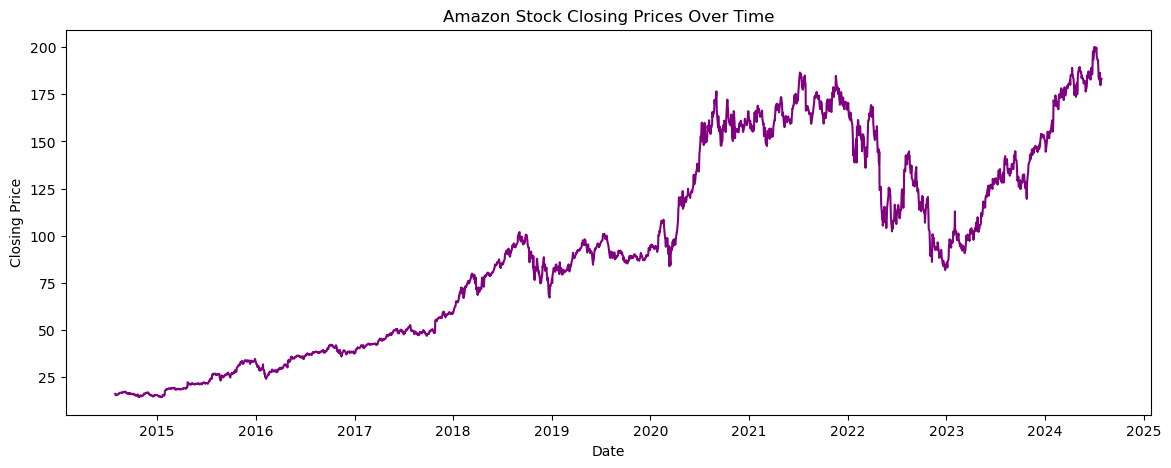

In [13]:
# plot closing prices over time
plt.figure(figsize=(14, 5))
plt.plot(stock_data['Close'], color='purple')
plt.title('Amazon Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

4. Time-Series Decomposition

Decompose the time-series to observe the trend, seasonality, and residual components.

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
# Decompose the time series
stock_result = seasonal_decompose(stock_data['Close'], model='multiplicative', period=365)

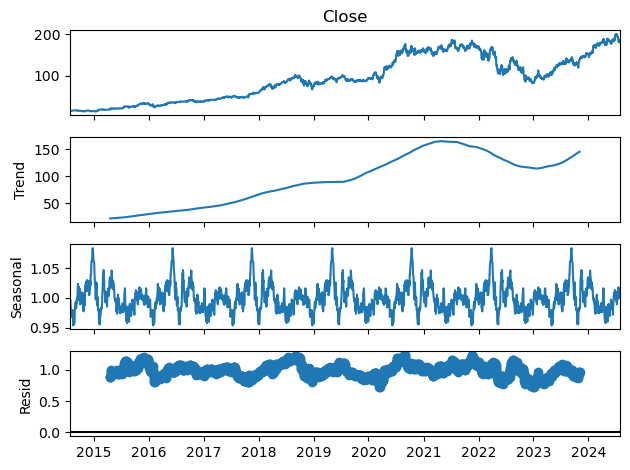

In [20]:
# Plot the decomposed components
stock_result.plot()
plt.show()

5. MODEL DEVELOPMENT

A. ARIMA MODEL (Autoregressive Integrated Moving Average Model)

Build an Arima model and evaluate for forecasting

In [60]:
# import necessary libraries
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as smapi
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Test for stationarity

Use the Augmented Dickey-Fuller (ADF) test to check for stationarity

A p-value below 0.05 indicates stationarity

In [61]:
adf_test = adfuller(stock_data['Close'])

# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.860792
p-value: 0.800610


Identify parameters (p, d, q) using ACF and PACF plots.

Fit the ARIMA model to the data.

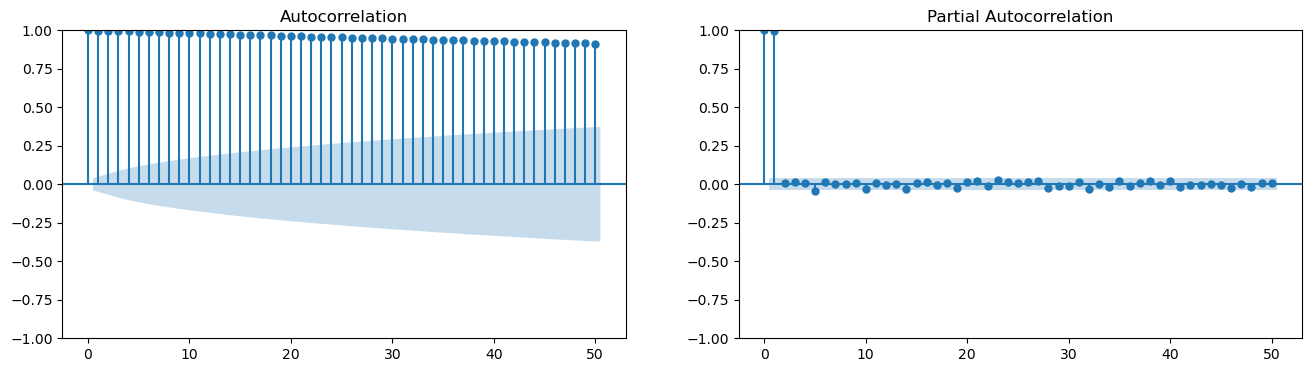

In [34]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(stock_data['Close'], lags=50, ax=axes[0])
plot_pacf(stock_data['Close'], lags=50, ax=axes[1])
plt.show()

In [35]:
# Split the data into training and testing sets
train_data, test_data = stock_data['Close'][:int(len(stock_data)*0.8)], stock_data['Close'][int(len(stock_data)*0.8):]

In [36]:
# Fit the ARIMA model
arima_model = ARIMA(train_data, order=(5, 1, 0))

In [37]:
series = stock_data['Close']
arima_model = smapi.tsa.arima.ARIMA(stock_data['Close'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()

In [45]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5554.902
Date:                Fri, 02 Aug 2024   AIC                          11121.805
Time:                        15:06:26   BIC                          11156.785
Sample:                             0   HQIC                         11134.500
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0205      0.013     -1.588      0.112      -0.046       0.005
ar.L2         -0.0154      0.014     -1.081      0.280      -0.043       0.013
ar.L3         -0.0270      0.013     -2.067      0.0

The above summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

In [38]:
# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test_data))

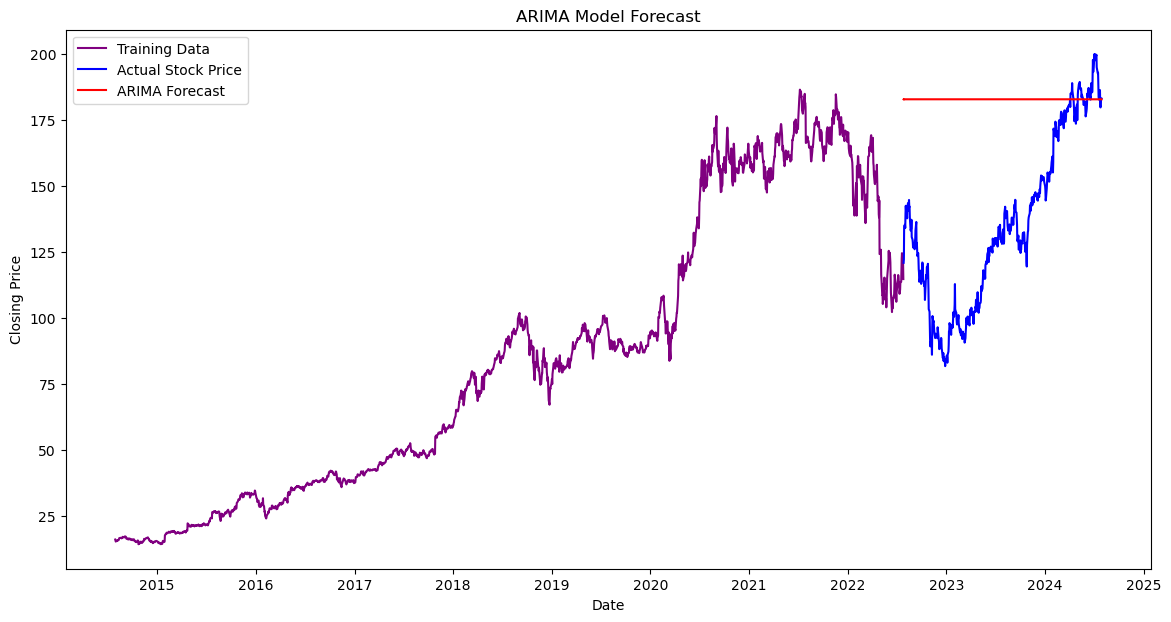

In [41]:
# Plot the forecast against actual data
plt.figure(figsize=(14, 7))
plt.plot(train_data, color='purple', label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(test_data.index, arima_forecast, color='red', label='ARIMA Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [46]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print(f'ARIMA Model RMSE: {rmse}')

ARIMA Model RMSE: 57.239228913065986


In [72]:
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    result = model.fit()
    output = result.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

stock_data['ARIMA'] = pd.DataFrame(predictions)

In [73]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 7.561


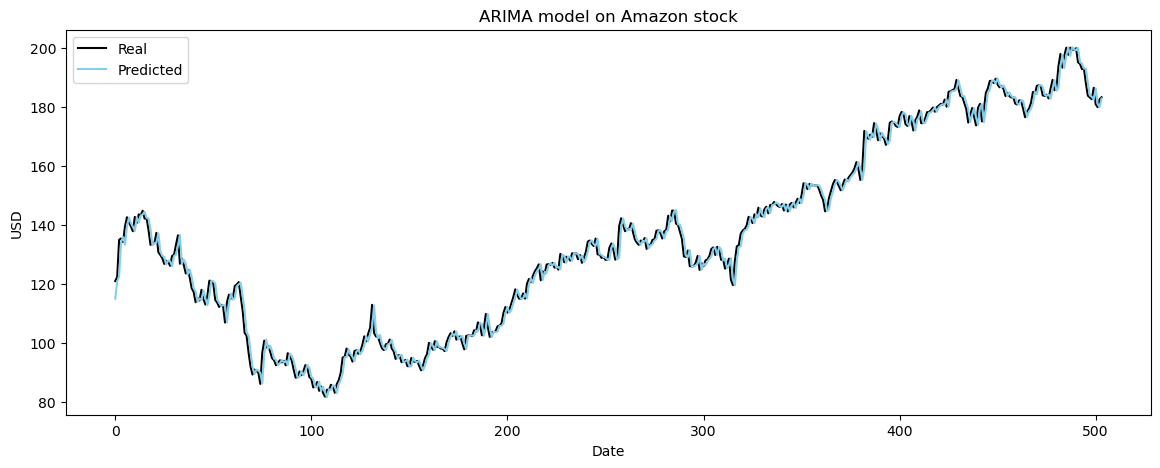

In [74]:
# Plot the predicted (from ARIMA) and real prices
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='skyblue', label='Predicted')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('ARIMA model on Amazon stock')
plt.legend()
plt.show()

B. SARIMA MODEL :Seasonal ARIMA for capturing seasonality.

Identify seasonal parameters (P, D, Q, s).

Fit the SARIMA model to the data.

Build and evaluate a SARIMA model for forecasting.

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [76]:
# Fit the SARIMA model
sarima_model = SARIMAX(train_data, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit()

In [77]:
# Forecast
sarima_forecast = sarima_model_fit.forecast(steps=len(test_data))

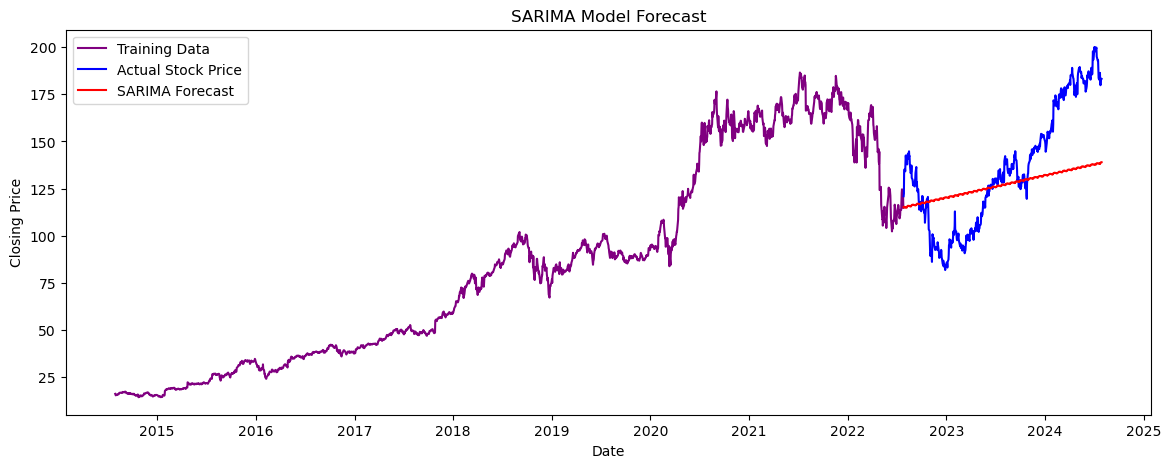

In [79]:
# Plot the forecast against actual data
plt.figure(figsize=(14, 5))
plt.plot(train_data, color='purple', label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(test_data.index, sarima_forecast, color='red', label='SARIMA Forecast')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [80]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
print(f'SARIMA Model RMSE: {rmse}')

SARIMA Model RMSE: 27.828928052639686


C. LSTM MODEL: Use Long Short-Term Memory networks for deep learning-based forecasting.

We'll try to predict the closing prices using 1 feature Open(It has highest correlation to closing price) initially and then using multiple features(use some sort of one hot encoding) and then try to get a output.

Prepare the data for LSTM (scaling, reshaping).

Build and Forecast the LSTM model 

In [91]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [82]:
# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

In [83]:
train_data_len = int(np.ceil(len(scaled_data) * 0.8))

In [84]:
# train and test data
train_data = scaled_data[0:int(train_data_len), :]
test_data = scaled_data[train_data_len - 60:, :]

In [85]:
# Create the training data
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [86]:
# Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [87]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [93]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [94]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [95]:
# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=80)

Epoch 1/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - loss: 0.0390
Epoch 2/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0023
Epoch 3/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0020
Epoch 4/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0021
Epoch 5/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0025
Epoch 6/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0018
Epoch 7/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0019
Epoch 8/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0020
Epoch 9/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0018
Epoch 10/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0027
Epoch 11/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0018
Epoch 12/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0020
Epoch 13/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0017
Epoch 14/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0016
Epoch 15/80
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0

In [96]:
# Create the testing data
x_test = []
y_test = scaled_data[train_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [97]:
# Convert x_test to a numpy array
x_test = np.array(x_test)

In [98]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [99]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [100]:
# Plot the data
train = stock_data[:train_data_len]
valid = stock_data[train_data_len:]
valid['Predictions'] = predictions

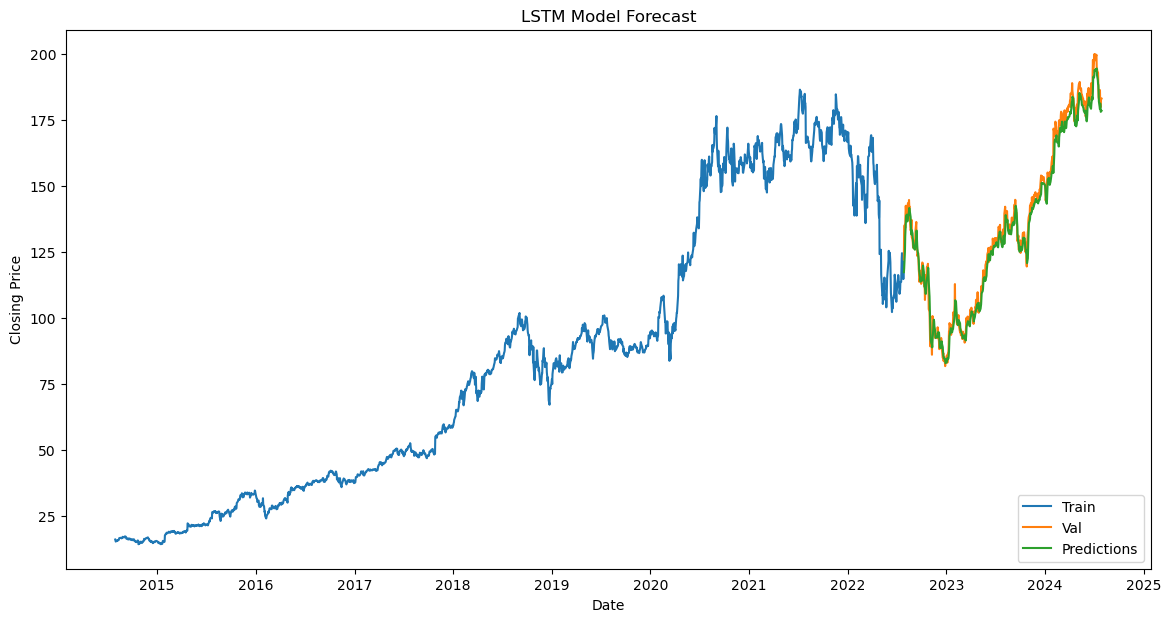

In [101]:
plt.figure(figsize=(14, 7))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [102]:
# Calculate the RMSE
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
print(f'LSTM Model RMSE: {rmse}')

LSTM Model RMSE: 136.33681966568247
